In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack
import lib
np.random.seed(666)

Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

Generate the 1D-DCT basis

In [3]:
DCT = lib.dct_matrix(M)
DCT.shape

(32, 32)

Generating the 1-D standard basis

In [4]:
C = np.eye(M)

Define the dictionary $D = [DCT, C]$

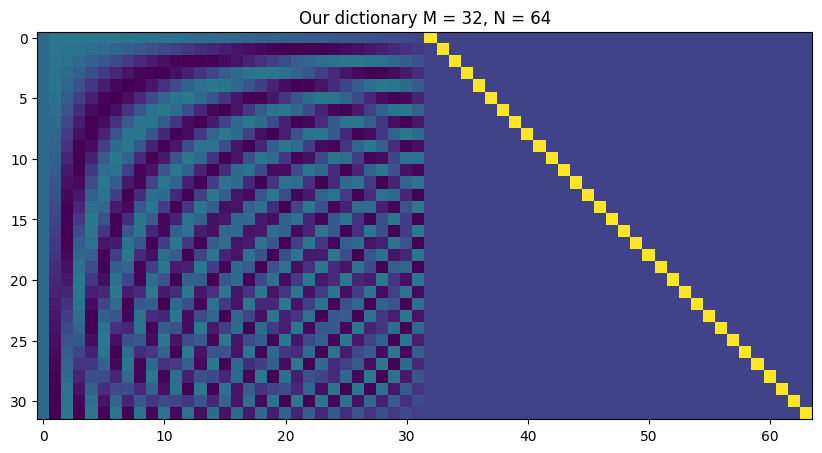

In [5]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}');

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 5
sigma_noise = 0.4

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

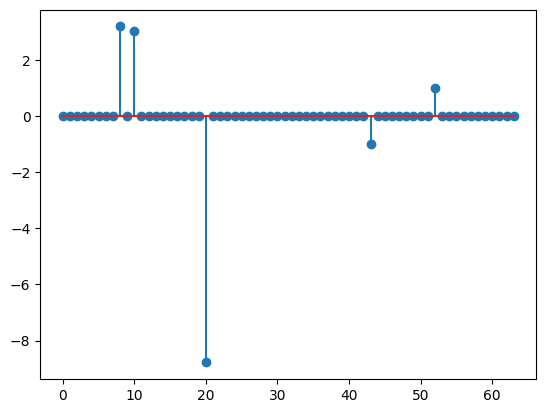

In [7]:
x0 = lib.Lsparse(N, L) * 5
x0[np.abs(x0) < 1] = 1 * np.sign(x0[np.abs(x0) < 1])
plt.stem(x0);



Choose spike location and update x0

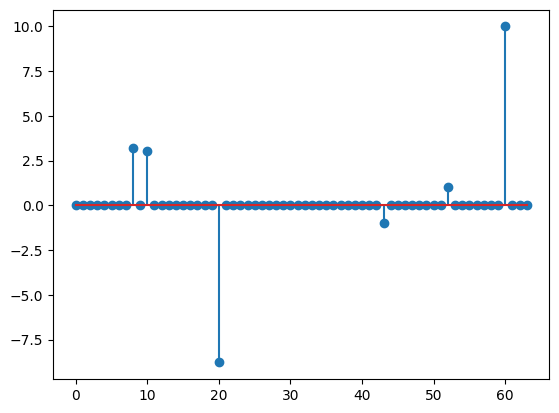

In [8]:
spikeLocation = np.random.choice(np.arange(M)[x0[M:] == 0], 1).item()
x0[M + spikeLocation] = 10
plt.stem(x0);

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M)

Plot the sparse signal

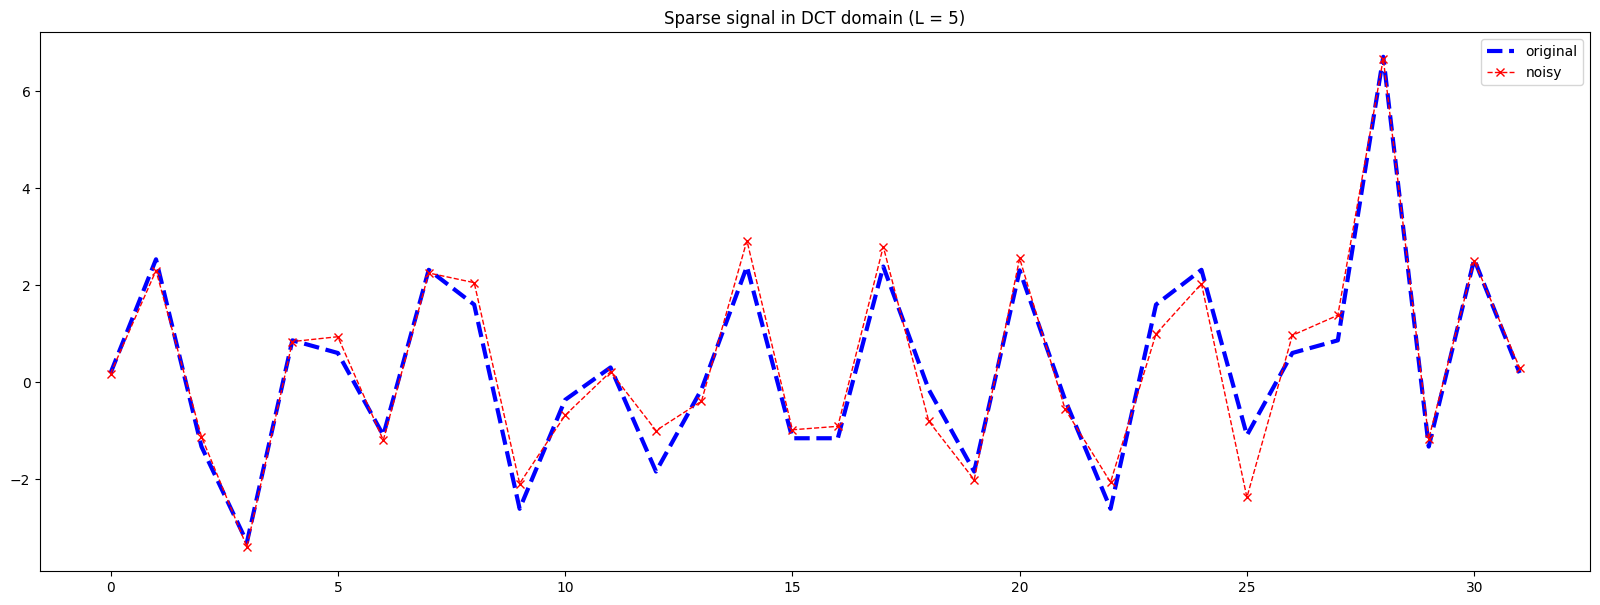

In [10]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(20, 7))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy']);

Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [11]:
x_MP = np.zeros(N)

r = s

l = 1

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r)

MINIMUM_RES_NORM = 0.1

MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [12]:
# while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:

#     # SWEEP STEP: look for the column of D that matches at best noisySignal
#     # compute the residual w.r.t. each column of D
#     e = np.zeros(N)
#     for j in range(N):
#         e[j] = resNorm ** 2 - np.dot(r, D[:, j]) ** 2
#         # this corresponds to solving e(j) = min( || dj zj - s ||),
#         # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
#         # there is no need to divide by || dj ||^2 since columns are nomalized

#     # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
#     jStar = np.argmin(e)

#     # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
#     x_MP[jStar] += np.dot(D[:, jStar], r)

#     # remove the signal we have so far represented in coeff_MP (update the residual)
#     r = s - D @ x_MP # component that cannot be captured by the signal (the signal at the very beginning)

#     l = l + 1

#     # update the residual norm
#     resNorm = np.linalg.norm(r)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [13]:
omp = lib.MatchingPursuit(L+1, lib.MatchingPursuit.Mode.ORTHOGONAL, max_iter=1000)
x_MP = omp.fit(D, s)
s_hat_MP = D @ x_MP

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [14]:
resNorm_MP = np.linalg.norm(s - s_hat_MP)
resNorm_MP

2.10972624081581

Show the result

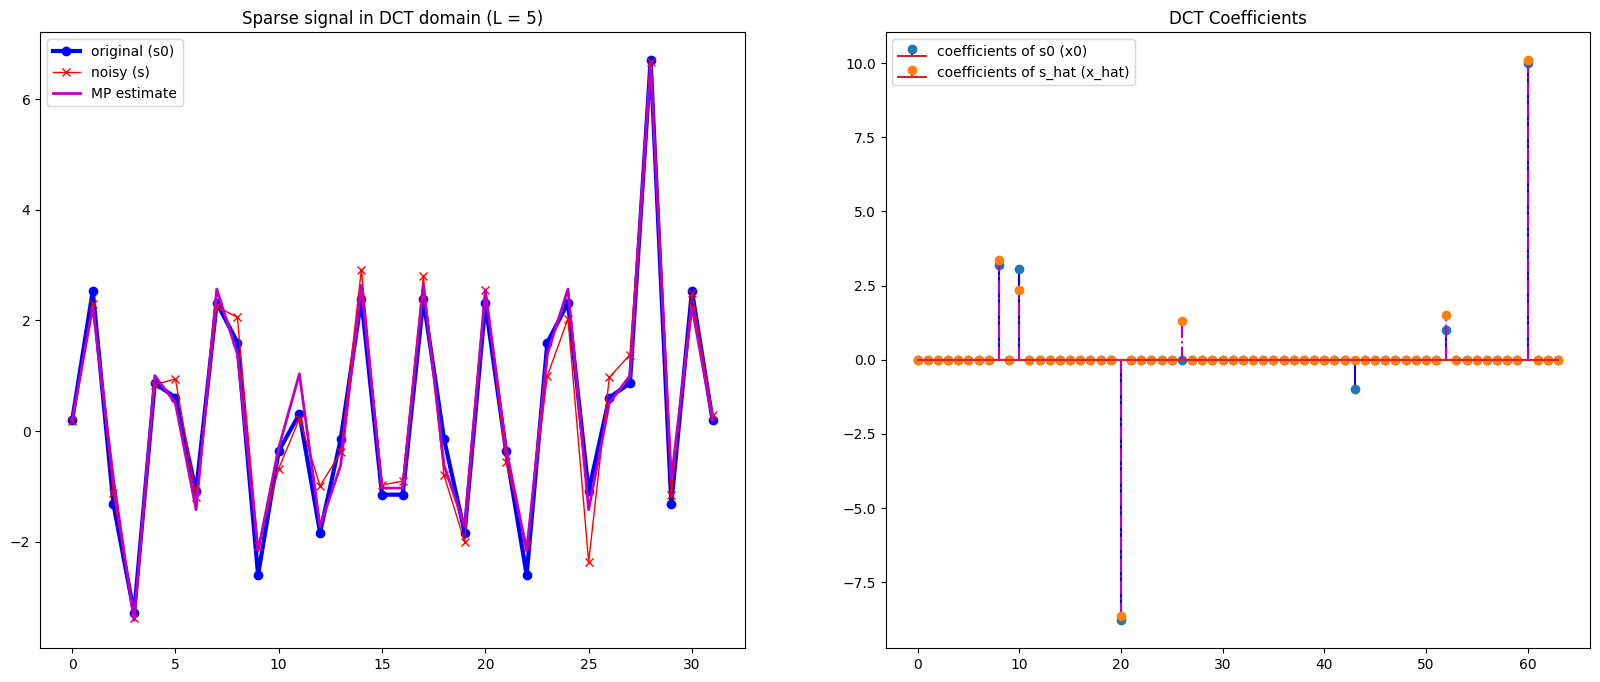

In [15]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)']);